# Wiener Parkplätze

## Parkflächen ermitteln
Quelle: Flächenmehrzweckkarte (FMZK) der Stadt Wien (https://www.data.gv.at/katalog/dataset/7cf0da04-1f77-4321-929e-78172c74aa0b)  
Stand: 15. Oktober 2024

Die FMZK enthält fehlerhafte Einträge:

```geopandas.read_file("fmzk.gpkg")```

```GEOSException: IllegalArgumentException: point array must contain 0 or >1 elements```

Umweg über QGIS:
* FMZK Geopackage importieren
* Layer filtern nach ```"F_KLASSE_TEXT" = "Ruhender Verkehr"```
* Layer CRS auf *EPSG: 31256* setzen
* Gefilterte Layer ohne Metadaten als Geopackage exportieren

*fmzk_parkflaechen.gpkg* in diesem Repo enthält die Parkflächen der FMZK.

(341222.0, 341422.0)

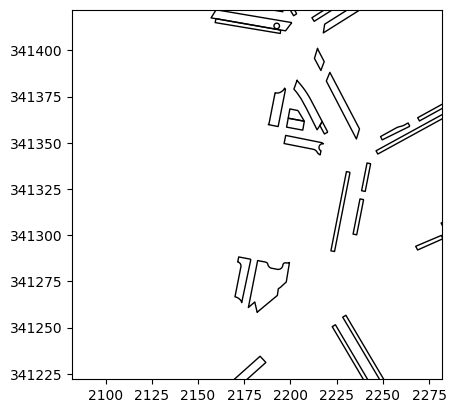

In [42]:
import geopandas as gpd

parkflaechen = gpd.read_file("datasets/parkflaechen.gpkg")

burg_x, burg_y = 2182, 341322
ax = parkflaechen.plot(facecolor="none")
ax.set_xlim([burg_x - 100, burg_x + 100])
ax.set_ylim([burg_y - 100, burg_y + 100])

## Parkflächen in einzelne Parkplätze aufteilen

### Largest interior rectangles finden
Parkflächen sind oft wenig rechtecksähnlich und können Löcher enthalten (z.B. Baumscheiben).  
Für die Aufteilung in einzelne Parkplätze zunächst die Parkflächen-Polygone mit möglichst großen Rechtecken füllen.  
Dafür gibts folgendes Package: https://github.com/OpenStitching/lir

Herausforderungen:
1. **Das LIR-Package findet nur axis-aligned LIRs**  
Parkflächen-Polygone sind beliebig orientiert
2. **Die Polygone müssen als binary grid vorliegen**  
Parkflächen-Polygone liegen als Gleitkomma EPSG:31256-Koordinaten vor mit Werten bis über 350.000. Ein Grid dieser Größe benötigt zu viel Speicher.

Lösungen:
1. **Achsenausrichtung**
    1. Minimum-Bounding-Rectangle (MBR) für Parkflächen-Polygon berechnen
    2. Winkel zwischen MBR und x-Achse berechnen
    3. Parkflächen-Polygon um berechneten Winkel rotieren
    4. LIR berechnen und zurückrotieren um Schwerpunkt des Originalpolygons
2. **Koordinaten normalisieren**
    1. EPSG:31256-Koordinaten des Polygon offsetten um Minimalkoordinate des Polygon
    2. Verkleinerte Koordinaten skalieren und runden, Genauigkeit von 10cm (resolution=0.1) ausreichend
    3. LIR berechnen und zurückskalieren bzw. -offsetten auf EPSG:31256-Koordinaten

Gefundenes LIR von Parkflächen-Polygon abschneiden und Algorithmus auf Restpolygon anwenden bis LIR kleiner als 2x6 bzw. 6x2 Meter. 
2 Meter ist eigentlich zu schmal für einen Parkplatz aber im Falle eines gekrümmten Parkflächen-Polygons sind die gefundenen LIRs stets schmäler als die originale Parkfläche.

Die meisten Parkflächen sind eh rechteckig - eine zweite, zeitintensive LIR-Berechnung nur anstarten wenn restliche Fläche groß genug für weiteren Parkplatz (ca. 12qm)

**Auf einem Macbook Air M1 rennt die Berechnung der LIRs für die gut 63.000 Parkflächen-Polygone etwa 30 Minuten.**

  0%|          | 0/63434 [00:00<?, ?it/s]

100%|██████████| 63434/63434 [26:21<00:00, 40.11it/s]   


(341222.0, 341422.0)

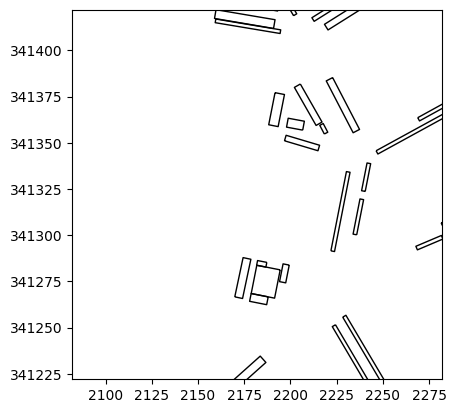

In [43]:
import numpy as np
import math
from shapely.geometry import MultiPolygon, box, Polygon
from shapely import affinity
import largestinteriorrectangle as lir
from rasterio.features import rasterize
from tqdm import tqdm


def align_to_xaxis(poly):
    min_rect = poly.minimum_rotated_rectangle
    rect_coords = list(min_rect.exterior.coords)

    if len(rect_coords) < 5:
        raise ValueError("Bounding rectangle does not have enough points")

    x1, y1 = rect_coords[0]
    x2, y2 = rect_coords[1]
    angle = -math.degrees(math.atan2(y2 - y1, x2 - x1))
    centroid = poly.centroid.coords[0]
    rotated_poly = affinity.rotate(poly, angle, origin=centroid, use_radians=False)

    return rotated_poly, angle, centroid


def normalize(poly, resolution):
    minx, miny, _, _ = poly.bounds
    
    exterior_coords = np.array(poly.exterior.coords)
    exterior_coords[:, 0] -= minx
    exterior_coords[:, 1] -= miny
    exterior_coords = (exterior_coords / resolution).round().astype(np.int32)

    interiors = []
    for interior in poly.interiors:
        interior_coords = np.array(interior.coords)
        interior_coords[:, 0] -= minx
        interior_coords[:, 1] -= miny
        interior_coords = (interior_coords / resolution).round().astype(np.int32)
        interiors.append(interior_coords)

    normalized_poly = Polygon(exterior_coords, interiors)

    return normalized_poly, (minx, miny)


def to_binary_grid(polygon):
    minx, miny, maxx, maxy = polygon.bounds
    if maxx == 0 or maxy == 0:
        return np.empty((1,1), np.bool)
    grid_size = (math.ceil(maxy),math.ceil(maxx))

    binary_grid = rasterize(
        [(polygon, 1)], 
        out_shape=grid_size, 
        fill=0, 
        all_touched=True
    )

    for hole in polygon.interiors:
        hole_poly = Polygon(hole)
        hole_grid = rasterize(
            [(hole_poly, 0)], 
            out_shape=grid_size, 
            fill=1,
            all_touched=True
        )
        binary_grid[hole_grid == 0] = 0 

    return binary_grid.astype(np.bool_)


def denormalize(rect, offset, resolution):
    x_normalized, y_normalized, width_normalized, height_normalized = rect
    minx, miny = offset
    x = x_normalized * resolution + minx
    y = y_normalized * resolution + miny
    width = width_normalized * resolution
    height = height_normalized * resolution
    maxx = x + width
    maxy = y + height

    return box(x, y, maxx, maxy)


def compute_all_lirs(parking_lane_polygon, min_dim1=2, min_dim2=5, resolution=0.1):
    rotated_poly, angle, centroid = align_to_xaxis(parking_lane_polygon)
    polys_queue = [rotated_poly]
    found_lirs = []

    while polys_queue:
        current_poly = polys_queue.pop()
        normalized_poly, offset = normalize(current_poly, resolution)
        normalized_poly_grid = to_binary_grid(normalized_poly)
        lir_normalized_rect = lir.lir(normalized_poly_grid)

        if lir_normalized_rect is None:
            continue
        
        lir_rotated = denormalize(lir_normalized_rect, offset, resolution)
        lx, ly, ux, uy = lir_rotated.bounds
        width = ux - lx
        height = uy - ly

        if not ((width >= min_dim1 and height >= min_dim2) or (width >= min_dim2 and height >= min_dim1)):
            continue
        
        found_lirs.append(lir_rotated)
        new_poly = current_poly.difference(lir_rotated)

        if new_poly.is_empty or new_poly.area < 10:
            continue
        
        if isinstance(new_poly, MultiPolygon):
          polys_queue.extend(list(new_poly.geoms))
        else:
          polys_queue.append(new_poly)
    
    final_lirs = [affinity.rotate(lir_, -angle, origin=centroid, use_radians=False) for lir_ in found_lirs]
    return final_lirs


tqdm.pandas()
parkflaechen_lirs = parkflaechen["geometry"].progress_apply(compute_all_lirs)
parkflaechen_lirs = [lir for sublist in parkflaechen_lirs for lir in sublist]
parkflaechen_lirs = gpd.GeoDataFrame({'geometry': parkflaechen_lirs}, crs=31256)

ax = parkflaechen_lirs.plot(facecolor="none")
ax.set_xlim([burg_x - 100, burg_x + 100])
ax.set_ylim([burg_y - 100, burg_y + 100])

Die Berechnung wollen wir nicht öfters ausführen müssen

In [44]:
parkflaechen_lirs.to_file('datasets/lirs.gpkg', driver='GPKG')

In [45]:
parkflaechen_lirs = gpd.read_file('datasets/lirs.gpkg')

### LIRs in Parkplätze aufteilen

1. Parkflächen-LIRs mit längster Seite parallel zur x-Achse rotieren.

2. Bestimmen ob die Parkfläche für Schräg- oder Parallelparker gedacht ist. Parkflächen für Schrägparker sind mindestens drei Meter breit (in y-Richtung, also kurze Seite des LIRs). Schmälere Parkstreifen sind für Parallelparker.

3. Je nach Parkstreifentyp das LIR der Länge nach (in x-Richtung) unterteilen: Parallelparkplätze sind mindestens sechs Meter lang, Schrägparkplätze mindestens drei Meter. Restlänge gleichmäßig auf die Parkplätze innerhalb des LIR verteilen.

4. Einzelparkplätze um den Schwerpunkt des LIR zurückrotieren. Den Rotationswinkel speichern weil er für die visuelle Darstellung der Parkplätze nützlich ist. 

100%|██████████| 52453/52453 [00:17<00:00, 3056.66it/s]


(341222.0, 341422.0)

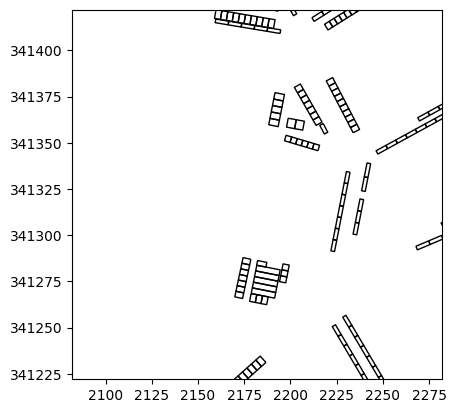

In [46]:
def split_parkflaeche(poly, min_parallel=6, min_perp=3):
    coords = list(poly.exterior.coords)[:-1]
    if len(coords) != 4:
        raise ValueError("Polygon does not have 4 vertices!")
    
    def dist(a, b):
        return math.hypot(b[0]-a[0], b[1]-a[1])
    
    d0 = dist(coords[0], coords[1])
    d1 = dist(coords[1], coords[2])
    
    if d0 >= d1:
        dx = coords[1][0] - coords[0][0]
        dy = coords[1][1] - coords[0][1]
    else:
        dx = coords[2][0] - coords[1][0]
        dy = coords[2][1] - coords[1][1]
    
    theta = math.degrees(math.atan2(dy, dx))
    
    cen = poly.centroid
    poly_rot = affinity.rotate(poly, -theta, origin=cen)
    
    minx, miny, maxx, maxy = poly_rot.bounds
    L_aligned = maxx - minx
    W_aligned = maxy - miny 
    
    is_parallel_parking = W_aligned < 3
    req = min_parallel if is_parallel_parking else min_perp
    
    n = int(math.floor(L_aligned / req))
    n = max(n, 1)
    
    spot_len = L_aligned / n
    
    spots = []
    for i in range(n):
        ll = (minx + i * spot_len, miny)
        ur = (minx + (i + 1) * spot_len, maxy)
        subrect = box(*ll, *ur)
        subrect_orig = affinity.rotate(subrect, theta, origin=cen)
        spots.append((subrect_orig, -theta - (90 if not is_parallel_parking else 0)))
    
    return spots


tqdm.pandas()
parkplaetze = parkflaechen_lirs['geometry'].progress_apply(split_parkflaeche)
parkplaetze = [lir for sublist in parkplaetze for lir in sublist]
parkplaetze = gpd.GeoDataFrame(parkplaetze, columns=['geometry', 'rotation'], crs=31256)

ax = parkplaetze.plot(facecolor="none")
ax.set_xlim([burg_x - 100, burg_x + 100])
ax.set_ylim([burg_y - 100, burg_y + 100])

## Parkplätze abspeichern
Ein GeoJSON mit allen Parkplatz-Polygonen umfasst etwa 80 MB. Zu groß um es auf einer Website an jeden Client zu übertragen.  

**Lösung**: Raster über Wien legen und jeweils Parkplatz-Polygone deren Mittelpunkt innerhalb einer Zelle liegt zu einem eigenen kleinem GeoJSON zusammenfassen. Clients laden nur jene GeoJSONs für den von ihnen betrachteten Kartenausschnitt (in Kombination mit einem minimalen Zoom-Level bevor Parkplätze überhaupt angezeigt werden).

Parkplätze werden auf der Karte mit in 22.5-Grad-Schritten vorrotierten, isometrischen Kfz-PNGs dargestellt.
Das *rotation*-Property im GeoJSON speichert die der exakten Parkplatz-Rotation naheliegendste PNG-Rotation.

*vehicle_id* speichert eine zufällig Zahl zwischen 0 und 4 um etwas Abwechslung in die dargestellten PNGs zu bringen.

In [47]:
import os
import shutil
from shapely.geometry import box

rotations = np.arange(0, 359, 22.5)
parkplaetze["rotation"] = parkplaetze["rotation"].apply(lambda degrees: round(rotations[np.abs(rotations - ((degrees + 360) % 360)).argmin()]))
parkplaetze["vehicle_id"] = np.random.randint(0, 5, size=len(parkplaetze))

parkplaetze = parkplaetze.to_crs(epsg=4326)
cell_size = 0.005
minx, miny, maxx, maxy = parkplaetze.total_bounds

def frange(start, stop, step):
    while start < stop:
        yield round(start, 6)
        start += step

cells = []
cell_ids = []
x_vals = list(frange(minx, maxx, cell_size))
y_vals = list(frange(miny, maxy, cell_size))

for ix, x0 in enumerate(x_vals):
    for iy, y0 in enumerate(y_vals):
        cell = box(x0, y0, x0 + cell_size, y0 + cell_size)
        cells.append(cell)
        cell_ids.append(f"x{ix}_y{iy}")

grid = gpd.GeoDataFrame({'cell_id': cell_ids, 'geometry': cells}, crs=4326)

parkplaetze = parkplaetze.to_crs(epsg=3857)
parkplaetze['centroid'] = parkplaetze.geometry.centroid
parkplaetze = parkplaetze.set_geometry('centroid')
parkplaetze = parkplaetze.to_crs(epsg=4326)

joined = gpd.sjoin(parkplaetze, grid, how="inner", predicate="within")
joined = joined.set_geometry('geometry')
joined = joined.to_crs(epsg=4326)

output_dir = "web/parkplaetze"
if os.path.exists(output_dir):
    shutil.rmtree(output_dir)
os.makedirs(output_dir)

for cell_id in joined['cell_id'].unique():
    subset = joined[joined['cell_id'] == cell_id].drop(columns=['index_right', 'centroid', 'cell_id'])
    subset = subset.reset_index()
    subset.to_file(f"{output_dir}/{cell_id}.geojson", driver="GeoJSON", id_field="index")

Beim Navigieren der interaktiven Karte muss in Javascript die aktuelle Position im Grid berechnet werden um das richtige GeoJSON zu laden. Dafür brauchen wir dort die ```total_bounds``` der Parkplätze und die Maschenweite des Grids (= 0.005 in WSG84) als magische Konstanten.

In [48]:
parkplaetze.total_bounds

array([16.20187827, 48.12305389, 16.54642621, 48.31233474])

Und der 'fun'-fact zum Schluss.

(Mindest-) Anzahl der (Straßen-) Parkplätze in Wien:

In [49]:
parkplaetze.shape[0]

241468

🥲